In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_HIGHTOL.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv_HIGHTOL.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [2]:
# Full 6D r,v elements

df

x             y             z      x_vv      y_vv      z_vv
0    42159.783600      0.000000      0.000000  0.000000  3.074505  0.053666
1    39159.545489  15563.916192    266.913396 -1.142984  2.852848  0.048528
2    30572.240101  28909.065576    496.928457 -2.127756  2.228986  0.039518
3    17596.058985  38144.724801    671.355898 -2.813645  1.287414  0.027234
4     2068.443209  41949.722913    775.646911 -3.098444  0.161674  0.012698
..            ...           ...           ...       ...       ...       ...
995  38234.560983  21122.626943  -7729.980003 -0.857195  2.210305  1.746021
996  31594.564686  31056.038869   1622.694286 -1.676526  1.578339  1.821188
997  21172.777063  37155.711937  10779.298456 -2.301089  0.745975  1.670545
998   8179.033302  38600.411058  18585.398385 -2.656710 -0.200198  1.303776
999  -5831.459789  35054.731864  23983.498223 -2.684504 -1.159193  0.748764

[1000 rows x 6 columns]

Function to train model on ONE column:

In [3]:
#Function

def train_vector(df, str):
    
    #Create a new dataframe with only the column
    data = df.filter([str]) # CHANGE FOR Y,Z
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * 0.8 ))
    train=dataset[0 : training_data_len]
    test=dataset[training_data_len - 60 : ]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train)
    test_data=scaler.transform(test)
    
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            pass
            #print(x_train)
            #print(y_train)
            #print()      
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Create the testing data set
    #Create a new array containing scaled values
    #Create the data sets x_test and y_test
    x_test = []
    #y_test = dataset[training_data_len:, :]
    y_test = dataset[training_data_len : ]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    
    #Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(x_train, y_train, batch_size=256, epochs=100) # 100 epochs
    
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    #print(predictions)
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    # Init empty predictions DF
    #df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])
    df_pred[str]=pred_s
    
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('\n RMSE:')
    print(rmse)
    
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Visualization of vector '+str)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel(str+'-Coord', fontsize=18)
    plt.plot(train[str])
    plt.plot(valid[[str, 'Predictions']])
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()

    # Error plot
    valid['Error']=abs(valid.Predictions-valid[str])/6738 # the normalization ct is taken as ISS semi-major axis
    valid.Error.plot()
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

We want to train all the 6 separate state space elements:

Epoch 1/100
3/3 [==============================] - 0s 128ms/step - loss: 0.2545
Epoch 2/100
3/3 [==============================] - 0s 124ms/step - loss: 0.1571
Epoch 3/100
3/3 [==============================] - 0s 122ms/step - loss: 0.1359
Epoch 4/100
3/3 [==============================] - 0s 113ms/step - loss: 0.1404
Epoch 5/100
3/3 [==============================] - 0s 114ms/step - loss: 0.1353
Epoch 6/100
3/3 [==============================] - 0s 111ms/step - loss: 0.1219
Epoch 7/100
3/3 [==============================] - 0s 111ms/step - loss: 0.1181
Epoch 8/100
3/3 [==============================] - 0s 109ms/step - loss: 0.1117
Epoch 9/100
3/3 [==============================] - 0s 113ms/step - loss: 0.1006
Epoch 10/100
3/3 [==============================] - 0s 123ms/step - loss: 0.0934
Epoch 11/100
3/3 [==============================] - 0s 110ms/step - loss: 0.0791
Epoch 12/100
3/3 [==============================] - 0s 122ms/step - loss: 0.0616
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 193ms/step - loss: 1.7831e-04
Epoch 99/100
3/3 [==============================] - 1s 217ms/step - loss: 1.7428e-04
Epoch 100/100
3/3 [==============================] - 1s 196ms/step - loss: 1.7059e-04

 RMSE:
1077.5304624674304


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


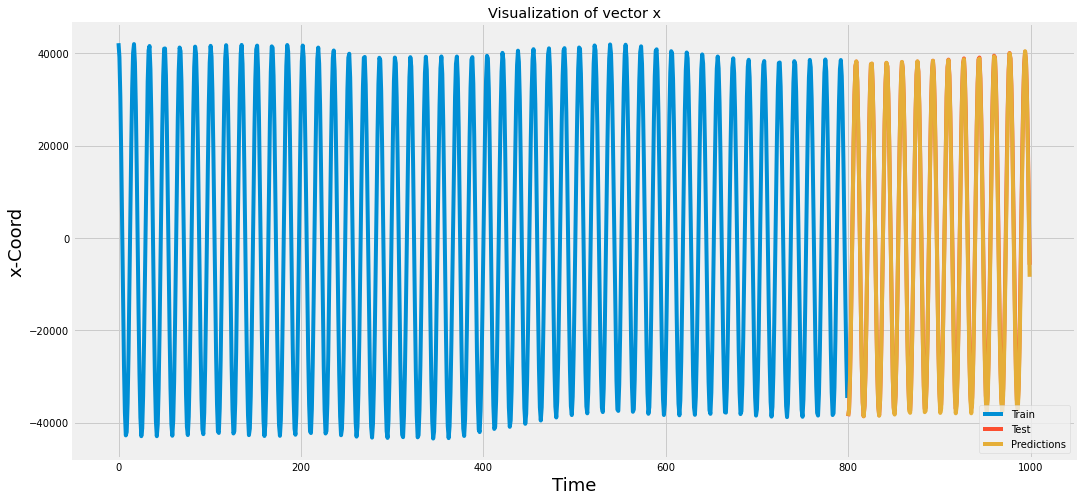

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 0s 145ms/step - loss: 0.2869
Epoch 2/100
3/3 [==============================] - 0s 157ms/step - loss: 0.1595
Epoch 3/100
3/3 [==============================] - 0s 153ms/step - loss: 0.1427
Epoch 4/100
3/3 [==============================] - 0s 146ms/step - loss: 0.1416
Epoch 5/100
3/3 [==============================] - 0s 150ms/step - loss: 0.1363
Epoch 6/100
3/3 [==============================] - 0s 141ms/step - loss: 0.1232
Epoch 7/100
3/3 [==============================] - 0s 145ms/step - loss: 0.1176
Epoch 8/100
3/3 [==============================] - 0s 160ms/step - loss: 0.1108
Epoch 9/100
3/3 [==============================] - 0s 142ms/step - loss: 0.1003
Epoch 10/100
3/3 [==============================] - 0s 137ms/step - loss: 0.0916
Epoch 11/100
3/3 [==============================] - 0s 142ms/step - loss: 0.0780
Epoch 12/100
3/3 [==============================] - 0s 133ms/step - loss: 0.0623
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 124ms/step - loss: 1.5869e-04
Epoch 99/100
3/3 [==============================] - 0s 119ms/step - loss: 1.5609e-04
Epoch 100/100
3/3 [==============================] - 0s 122ms/step - loss: 1.5782e-04

 RMSE:
814.4020171338078


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


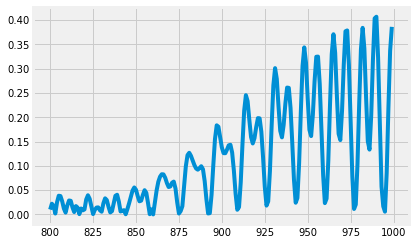

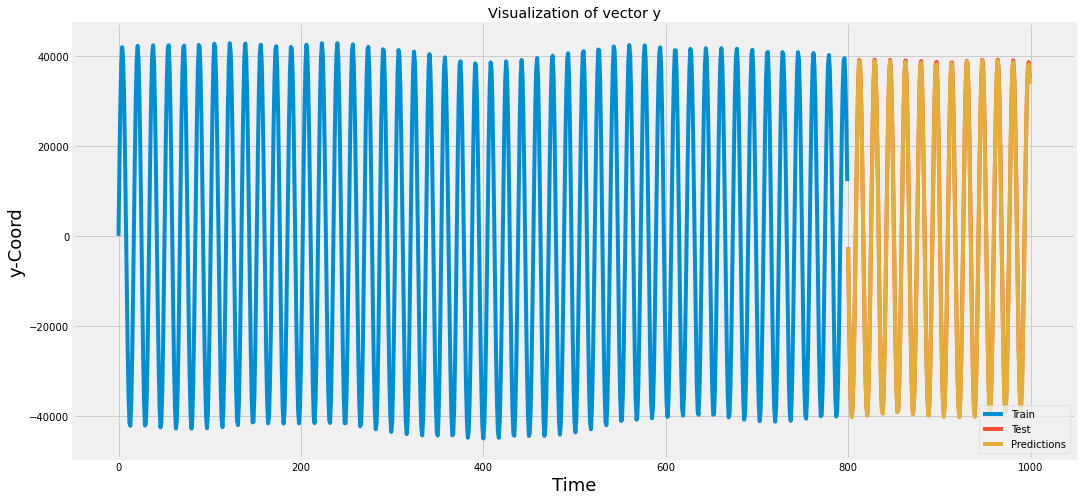

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 206ms/step - loss: 0.1826
Epoch 2/100
3/3 [==============================] - 1s 232ms/step - loss: 0.0831
Epoch 3/100
3/3 [==============================] - 1s 216ms/step - loss: 0.0656
Epoch 4/100
3/3 [==============================] - 1s 205ms/step - loss: 0.0692
Epoch 5/100
3/3 [==============================] - 1s 206ms/step - loss: 0.0680
Epoch 6/100
3/3 [==============================] - 1s 195ms/step - loss: 0.0603
Epoch 7/100
3/3 [==============================] - 1s 195ms/step - loss: 0.0594
Epoch 8/100
3/3 [==============================] - 1s 198ms/step - loss: 0.0582
Epoch 9/100
3/3 [==============================] - 1s 190ms/step - loss: 0.0545
Epoch 10/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0543
Epoch 11/100
3/3 [==============================] - 1s 181ms/step - loss: 0.0530
Epoch 12/100
3/3 [==============================] - 1s 174ms/step - loss: 0.0500
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 133ms/step - loss: 1.3007e-04
Epoch 99/100
3/3 [==============================] - 0s 122ms/step - loss: 1.3424e-04
Epoch 100/100
3/3 [==============================] - 0s 124ms/step - loss: 1.3238e-04

 RMSE:
617.8648670202612


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


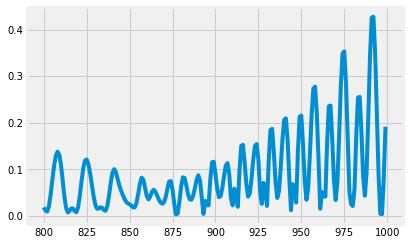

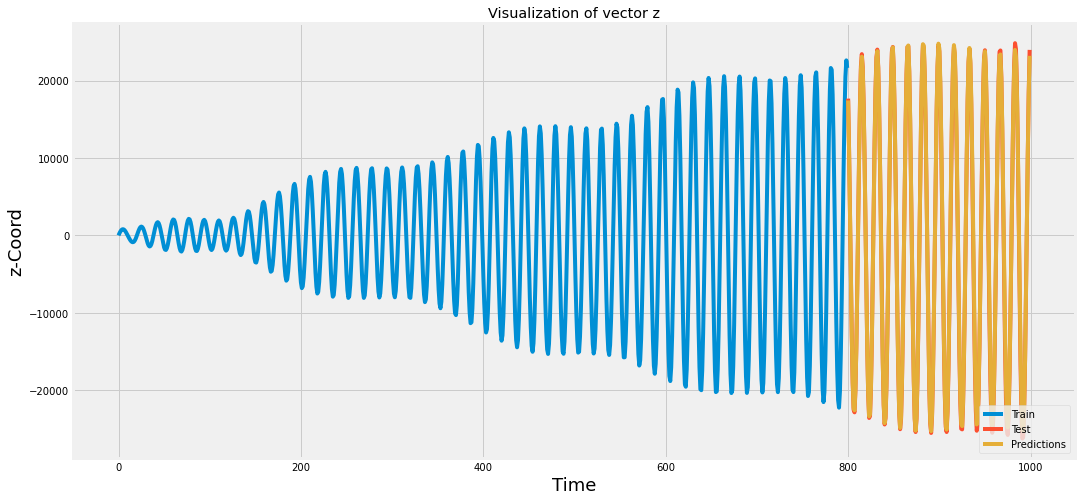

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 0s 117ms/step - loss: 0.2390
Epoch 2/100
3/3 [==============================] - 0s 117ms/step - loss: 0.1672
Epoch 3/100
3/3 [==============================] - 0s 110ms/step - loss: 0.1287
Epoch 4/100
3/3 [==============================] - 1s 255ms/step - loss: 0.1378
Epoch 5/100
3/3 [==============================] - 1s 305ms/step - loss: 0.1340
Epoch 6/100
3/3 [==============================] - 1s 325ms/step - loss: 0.1191
Epoch 7/100
3/3 [==============================] - 1s 305ms/step - loss: 0.1139
Epoch 8/100
3/3 [==============================] - 1s 249ms/step - loss: 0.1109
Epoch 9/100
3/3 [==============================] - 1s 221ms/step - loss: 0.0990
Epoch 10/100
3/3 [==============================] - 1s 235ms/step - loss: 0.0928
Epoch 11/100
3/3 [==============================] - 1s 210ms/step - loss: 0.0808
Epoch 12/100
3/3 [==============================] - 1s 216ms/step - loss: 0.0640
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 120ms/step - loss: 2.0121e-04
Epoch 99/100
3/3 [==============================] - 0s 124ms/step - loss: 2.0124e-04
Epoch 100/100
3/3 [==============================] - 0s 120ms/step - loss: 2.0077e-04

 RMSE:
0.06438279774992668


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


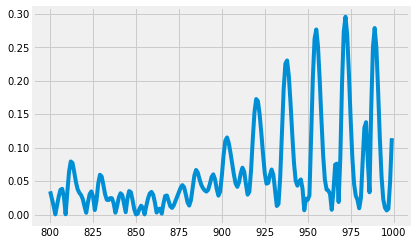

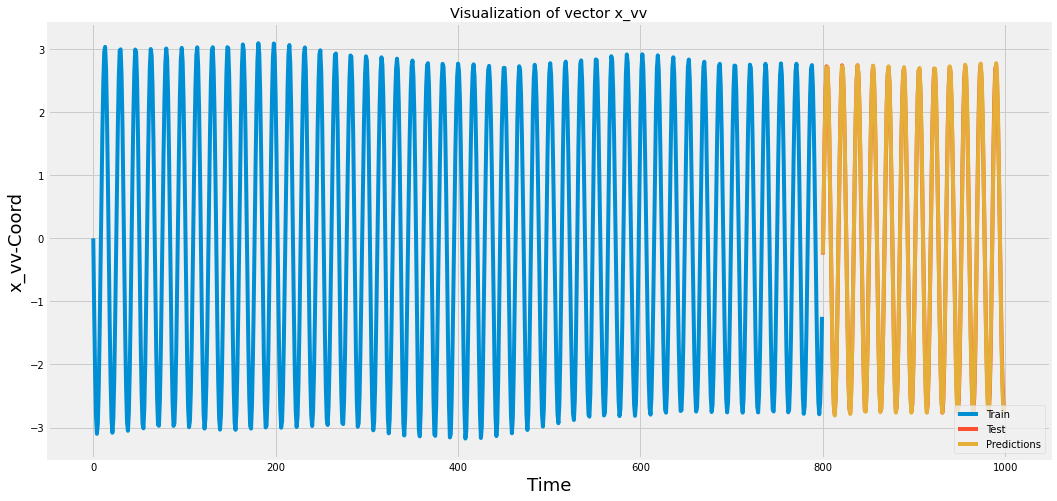

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 211ms/step - loss: 0.3115
Epoch 2/100
3/3 [==============================] - 1s 221ms/step - loss: 0.1540
Epoch 3/100
3/3 [==============================] - 1s 214ms/step - loss: 0.1487
Epoch 4/100
3/3 [==============================] - 1s 200ms/step - loss: 0.1385
Epoch 5/100
3/3 [==============================] - 1s 187ms/step - loss: 0.1393
Epoch 6/100
3/3 [==============================] - 1s 190ms/step - loss: 0.1266
Epoch 7/100
3/3 [==============================] - 1s 194ms/step - loss: 0.1171
Epoch 8/100
3/3 [==============================] - 1s 182ms/step - loss: 0.1133
Epoch 9/100
3/3 [==============================] - 1s 189ms/step - loss: 0.1041
Epoch 10/100
3/3 [==============================] - 1s 173ms/step - loss: 0.0953
Epoch 11/100
3/3 [==============================] - 1s 175ms/step - loss: 0.0859
Epoch 12/100
3/3 [==============================] - 1s 185ms/step - loss: 0.0723
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 125ms/step - loss: 2.0287e-04
Epoch 99/100
3/3 [==============================] - 0s 129ms/step - loss: 2.0391e-04
Epoch 100/100
3/3 [==============================] - 0s 125ms/step - loss: 2.1702e-04

 RMSE:
0.06962641303065964


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


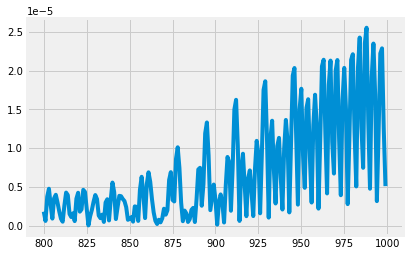

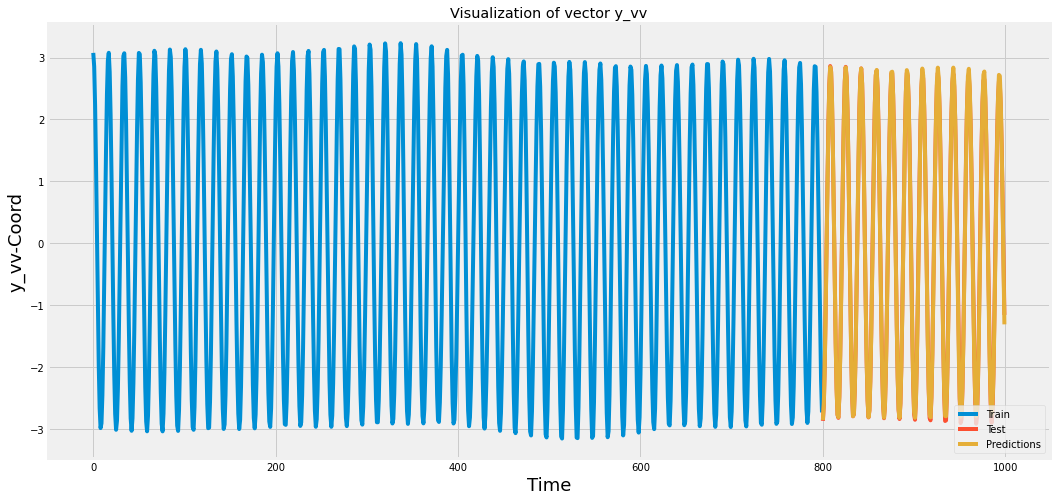

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 236ms/step - loss: 0.2122
Epoch 2/100
3/3 [==============================] - 1s 218ms/step - loss: 0.0799
Epoch 3/100
3/3 [==============================] - 1s 214ms/step - loss: 0.0719
Epoch 4/100
3/3 [==============================] - 1s 201ms/step - loss: 0.0677
Epoch 5/100
3/3 [==============================] - 1s 216ms/step - loss: 0.0701
Epoch 6/100
3/3 [==============================] - 1s 205ms/step - loss: 0.0619
Epoch 7/100
3/3 [==============================] - 1s 190ms/step - loss: 0.0596
Epoch 8/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0598
Epoch 9/100
3/3 [==============================] - 1s 187ms/step - loss: 0.0568
Epoch 10/100
3/3 [==============================] - 1s 179ms/step - loss: 0.0545
Epoch 11/100
3/3 [==============================] - 1s 182ms/step - loss: 0.0538
Epoch 12/100
3/3 [==============================] - 1s 177ms/step - loss: 0.0520
Epoch 13/100
3/3 [===================

3/3 [==============================] - 0s 149ms/step - loss: 1.2017e-04
Epoch 99/100
3/3 [==============================] - 0s 132ms/step - loss: 1.2044e-04
Epoch 100/100
3/3 [==============================] - 0s 145ms/step - loss: 1.2039e-04

 RMSE:
0.037415297699432734


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


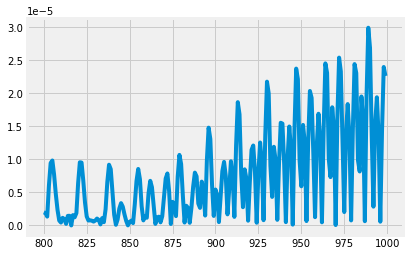

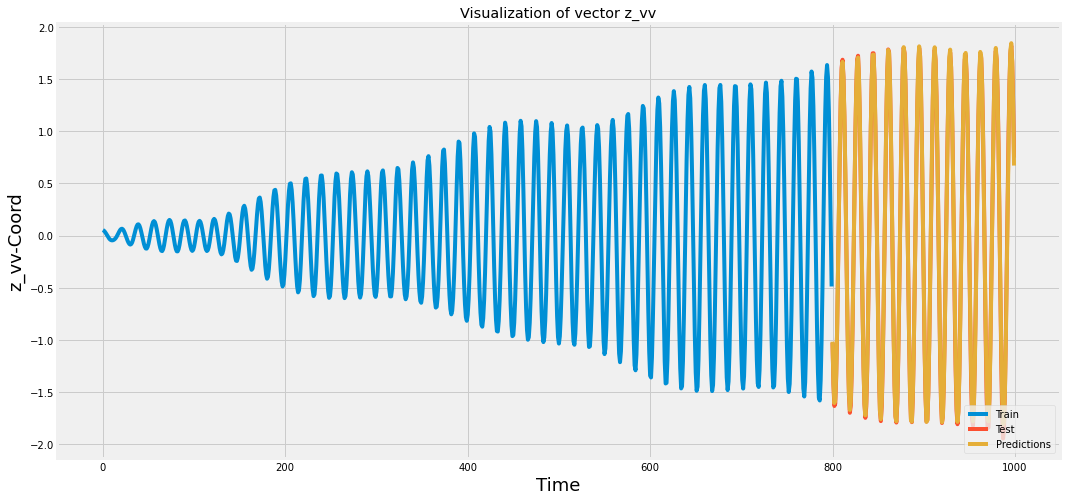

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


x             y             z      x_vv      y_vv      z_vv
0   -38553.335938  -2674.183594  17448.628906 -0.245058 -2.857060 -1.016281
1   -37130.996094 -17018.578125  11080.043945  0.764702 -2.597492 -1.411946
2   -30704.843750 -29068.347656   3121.751465  1.664168 -1.994614 -1.603521
3   -20170.964844 -37206.218750  -5303.611816  2.340999 -1.126511 -1.569711
4    -6938.910645 -40331.710938 -13012.461914  2.708558 -0.104852 -1.322119
..            ...           ...           ...       ...       ...       ...
195  38273.042969  20538.830078  -7661.025391 -0.937747  2.302519  1.777025
196  31021.898438  31027.357422   1664.233643 -1.826180  1.582206  1.844528
197  19702.585938  37131.148438  10721.560547 -2.455174  0.649135  1.659455
198   5910.957031  38058.738281  18253.058594 -2.741294 -0.361849  1.250433
199  -8433.075195  33765.191406  23214.851562 -2.650182 -1.311729  0.671870

[200 rows x 6 columns]

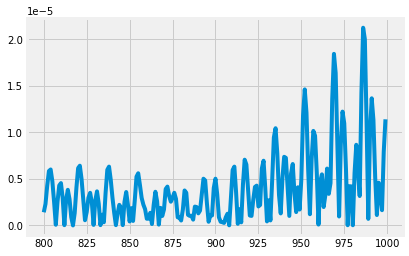

In [4]:
# 6D Call:

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])

for vector in list(df.columns):
    train_vector(df, vector)

df_pred

In [5]:
# Transform this df_pred to OE with the function transform.py

### Compare and plot results/errors SEPARATELY

In [6]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]
train_df = df[:train_size]

test_df

x             y             z      x_vv      y_vv      z_vv
800 -38621.084811  -2550.946846  17682.193978 -0.257209 -2.870446 -1.025837
801 -37279.380962 -16940.060722  11242.557363  0.768795 -2.610164 -1.427567
802 -30825.302422 -29006.586493   3208.718635  1.689373 -1.985552 -1.632349
803 -20158.481503 -37068.221540  -5302.080061  2.373066 -1.085660 -1.609145
804  -6770.864726 -40022.999588 -13103.503585  2.726621 -0.041149 -1.362677
..            ...           ...           ...       ...       ...       ...
995  38234.560983  21122.626943  -7729.980003 -0.857195  2.210305  1.746021
996  31594.564686  31056.038869   1622.694286 -1.676526  1.578339  1.821188
997  21172.777063  37155.711937  10779.298456 -2.301089  0.745975  1.670545
998   8179.033302  38600.411058  18585.398385 -2.656710 -0.200198  1.303776
999  -5831.459789  35054.731864  23983.498223 -2.684504 -1.159193  0.748764

[200 rows x 6 columns]

In [7]:
df_pred.index=test_df.index

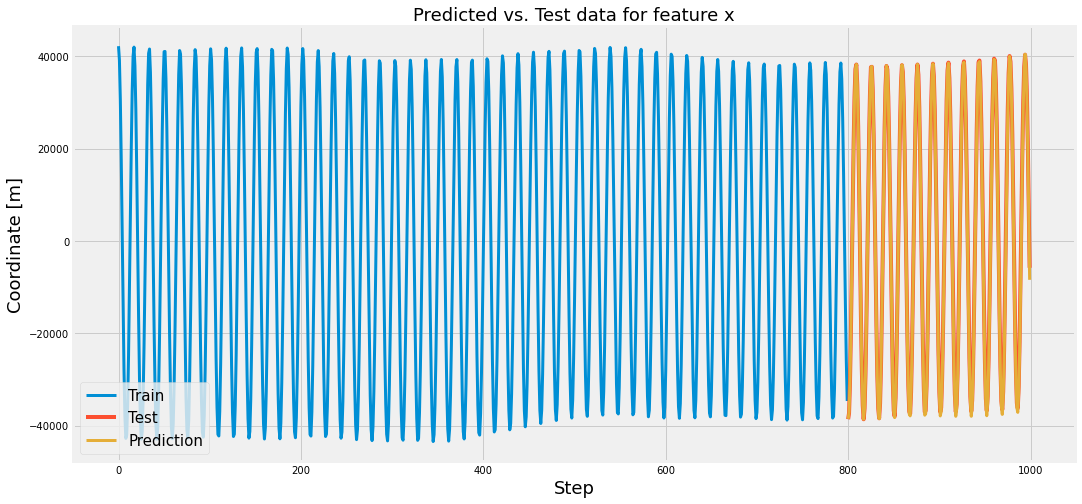

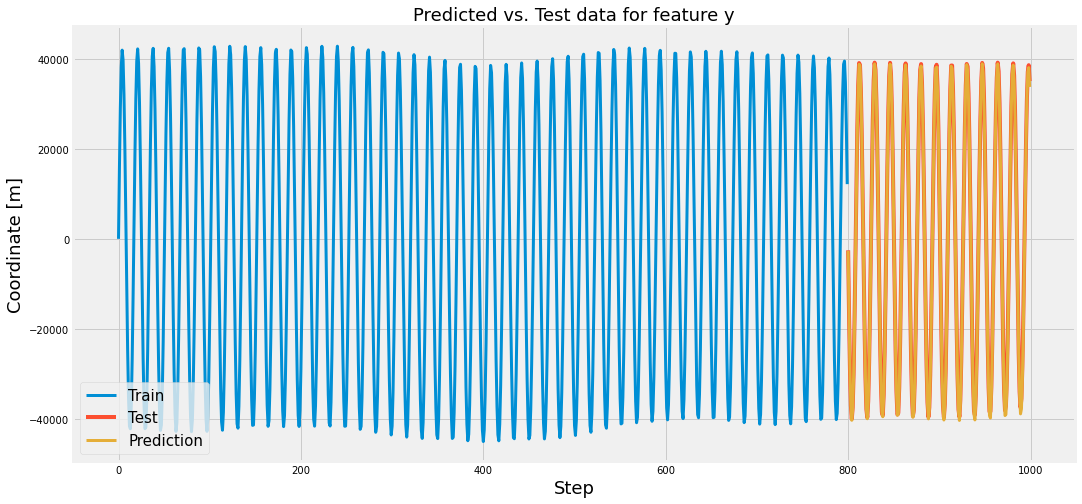

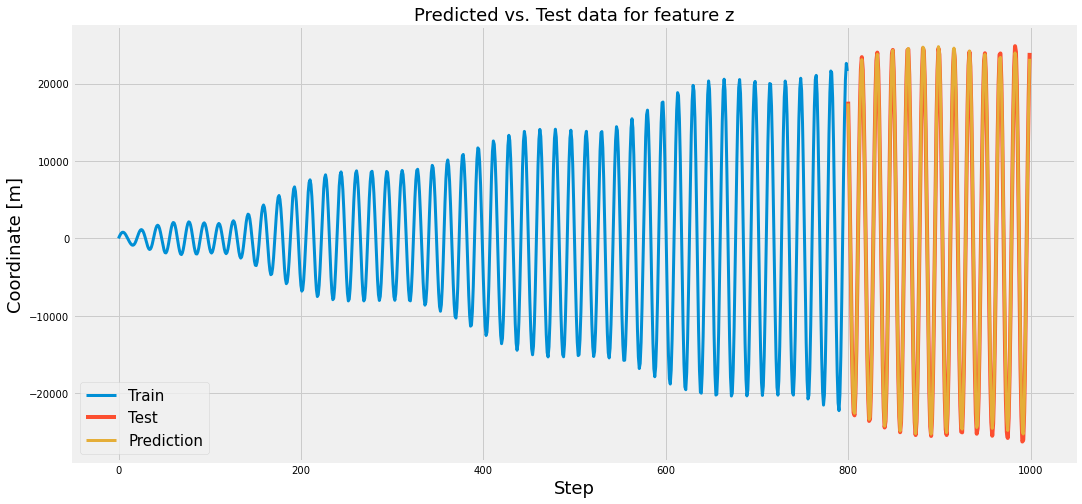

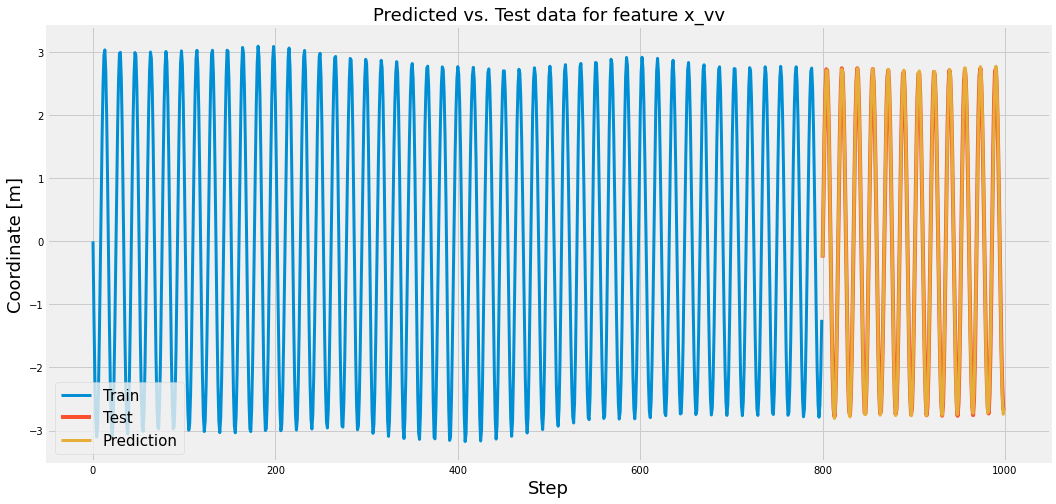

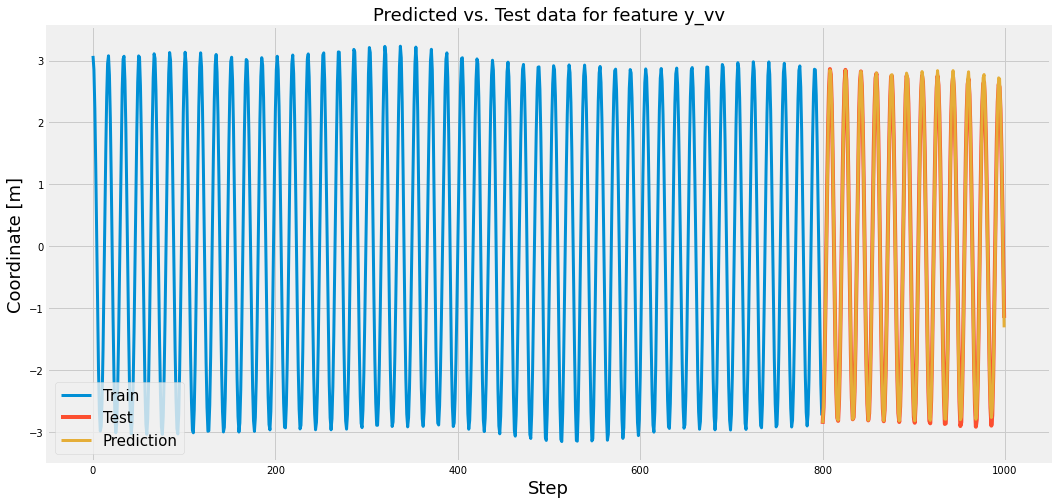

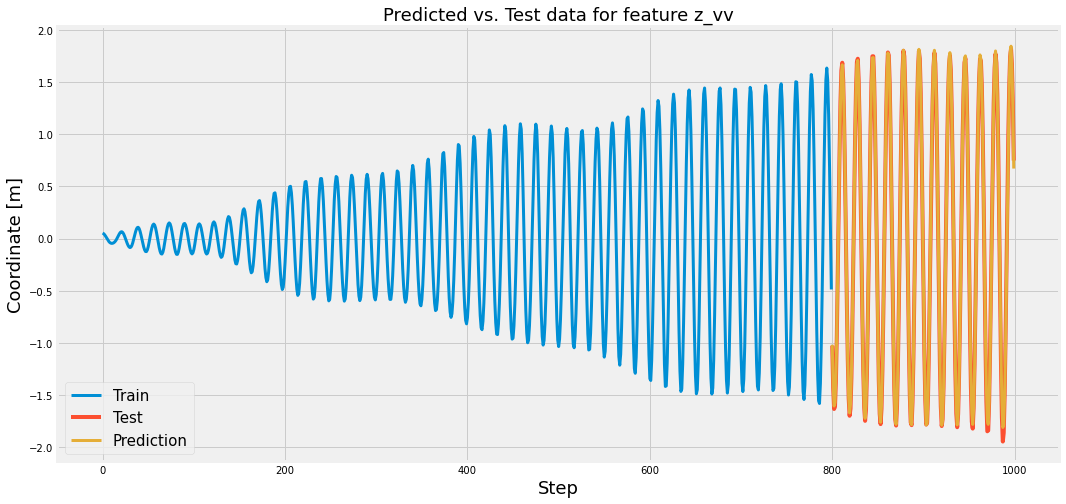

In [8]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature], linewidth=3)
    plt.plot(test_df[feature], linewidth=4)
    plt.plot(df_pred[feature], linewidth=3)

    plt.title(f'Predicted vs. Test data for feature {feature}', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Coordinate [m]', fontsize=18)
    plt.legend(['Train', 'Test', 'Prediction'], loc='lower left', fontsize=15)
    plt.show()


## RMSE:

In [16]:
print('RMSE for all Features:')
print()

for i in list(test_df.columns):
    print(i)
    rmse = np.sqrt(np.mean(((test_df[i] - df_pred[i]) ** 2)))
    print(rmse)

RMSE for all Features:

x
1077.5304624674304
y
814.4020171338078
z
617.8648670202612
x_vv
0.06438279774992668
y_vv
0.06962641303065964
z_vv
0.037415297699432734


## Absolute errors:

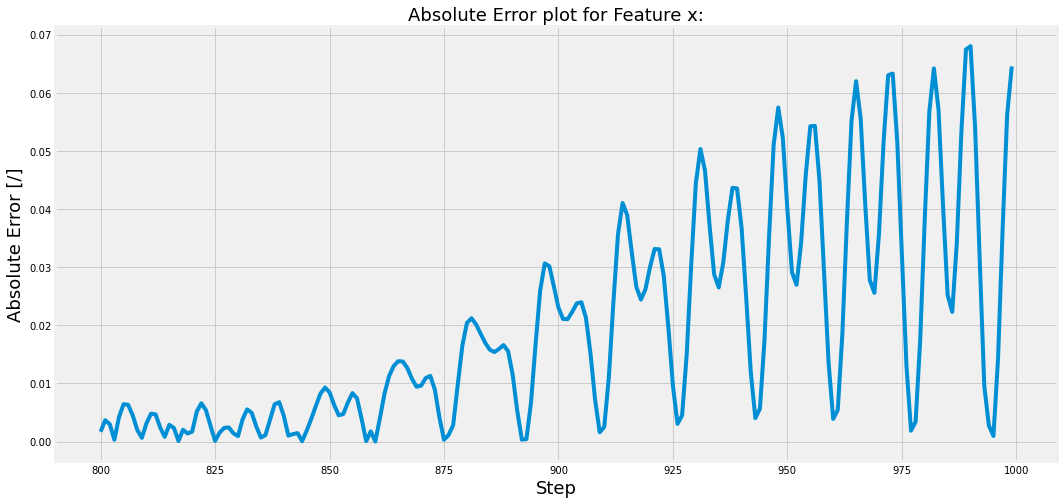

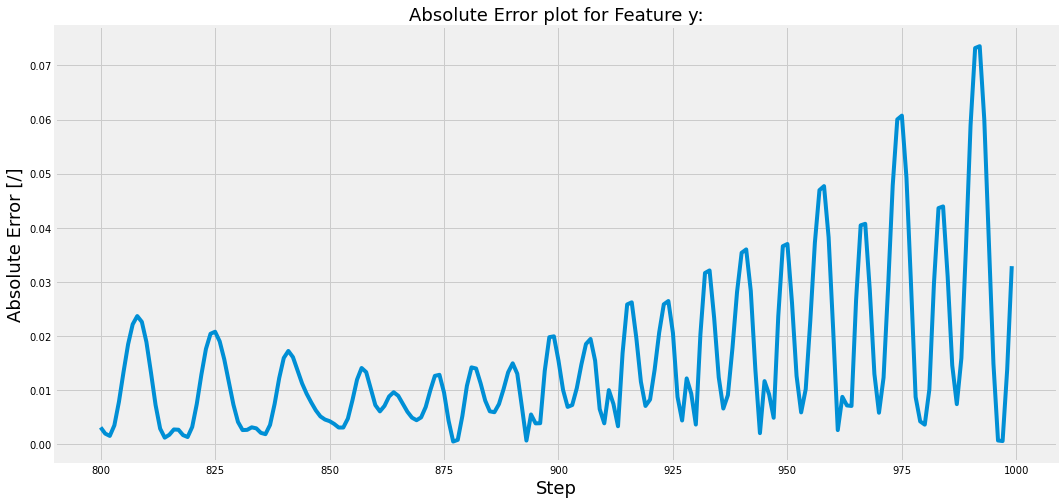

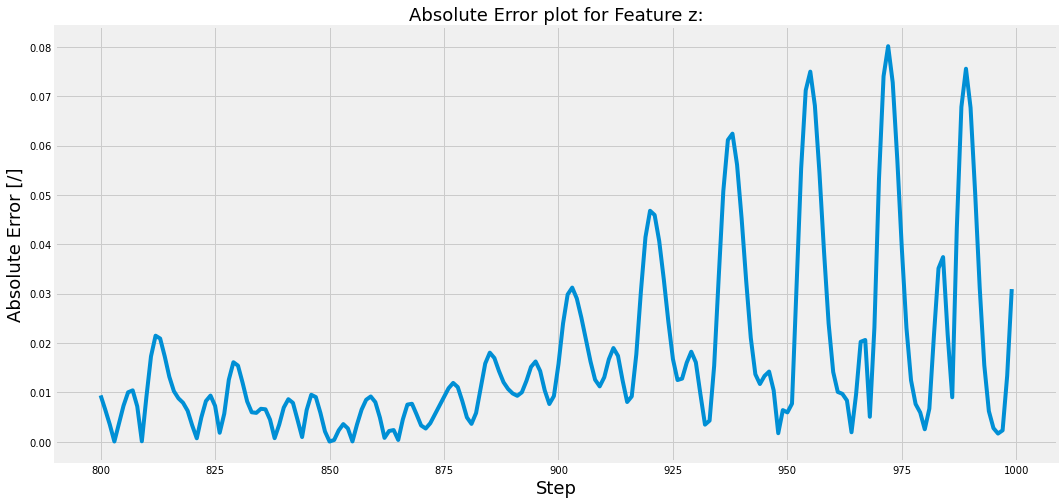

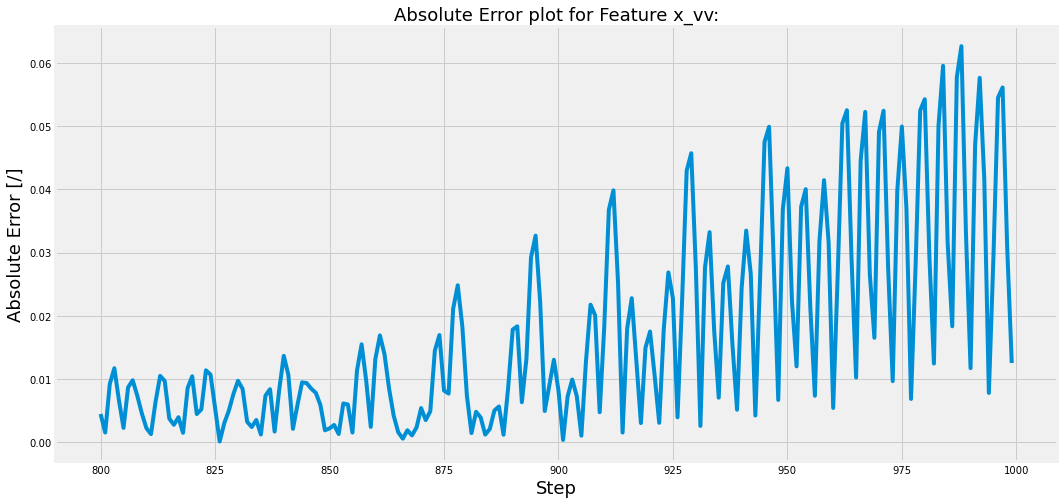

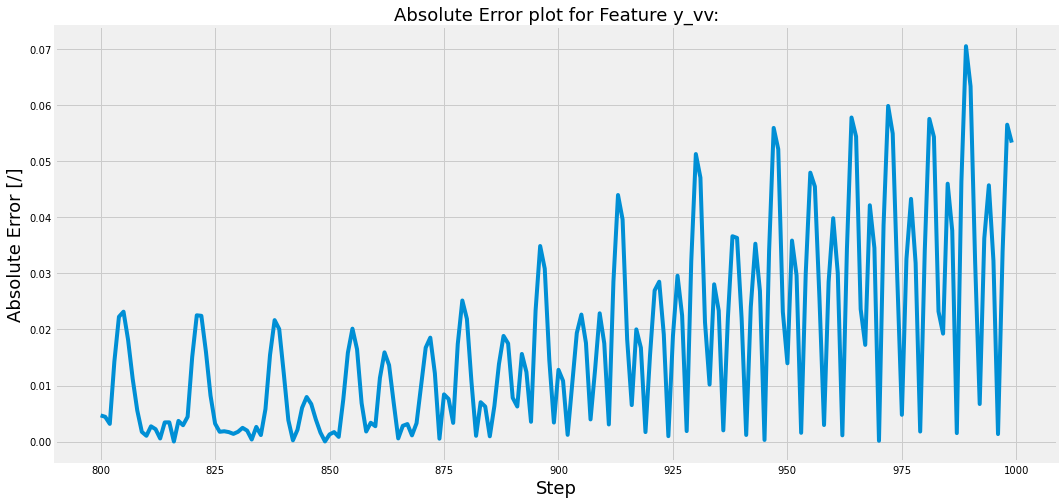

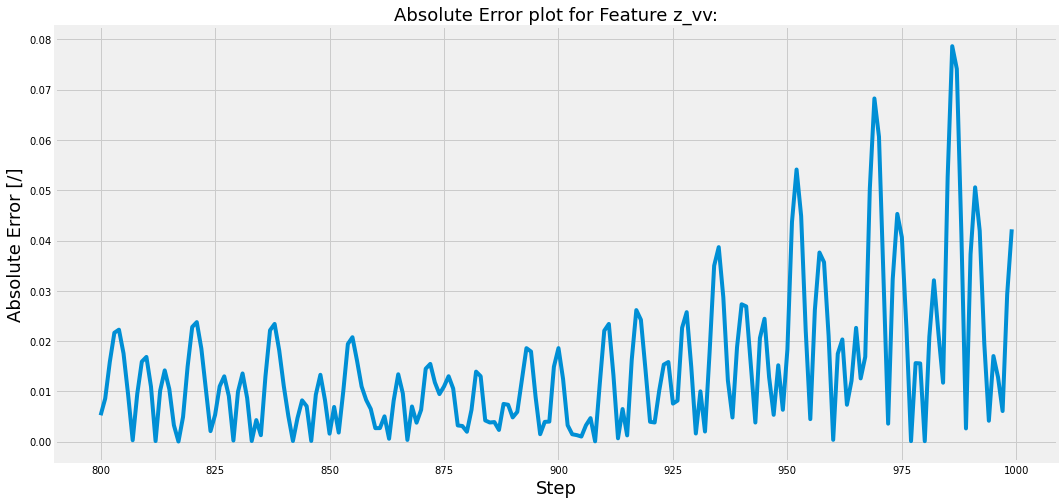

In [9]:
# ABSOLUTE ERRORS:

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/max(test_df[feature]))

    plt.title(f'Absolute Error plot for Feature {feature}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Absolute Error [/]', fontsize=18)
    plt.show()

In [17]:
# AVG ABSOLUTE ERRORS:

print('Mean Absolute Errors:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/max(test_df[i])
    print(abs_err.mean())

Mean Absolute Errors:

x
0.019444994688705582
y
0.015326347744305422
z
0.01724139237811306
x_vv
0.017252850969229586
y_vv
0.017918477152677824
z_vv
0.014917177831286411


## Relative errors:

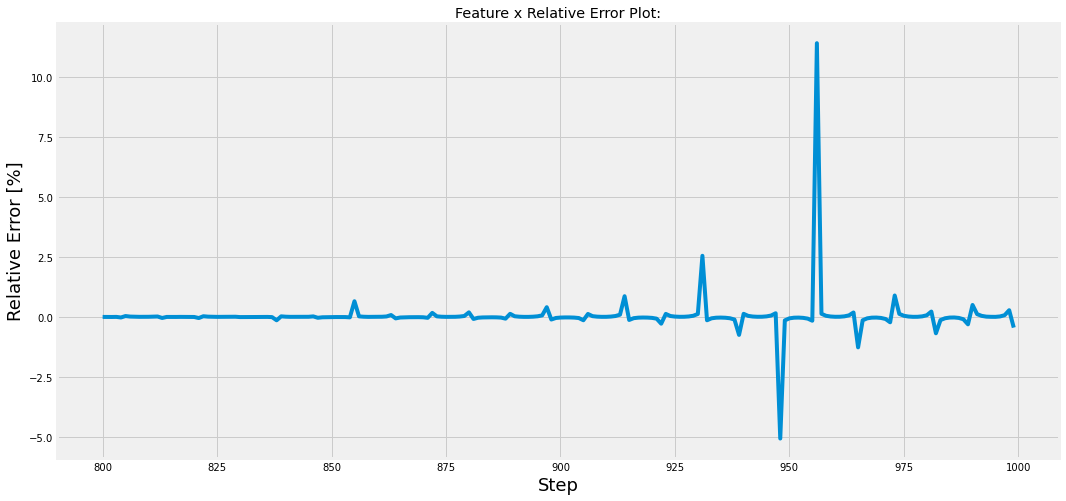

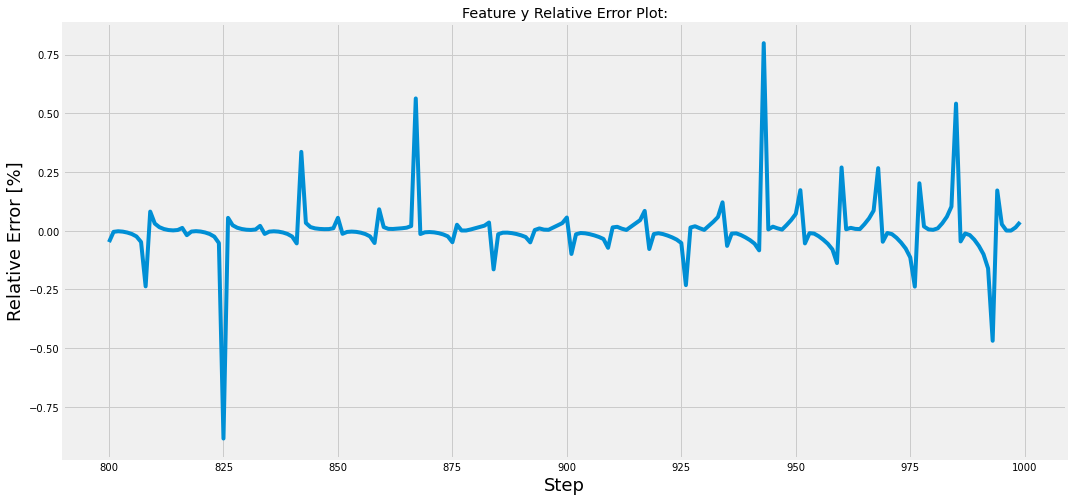

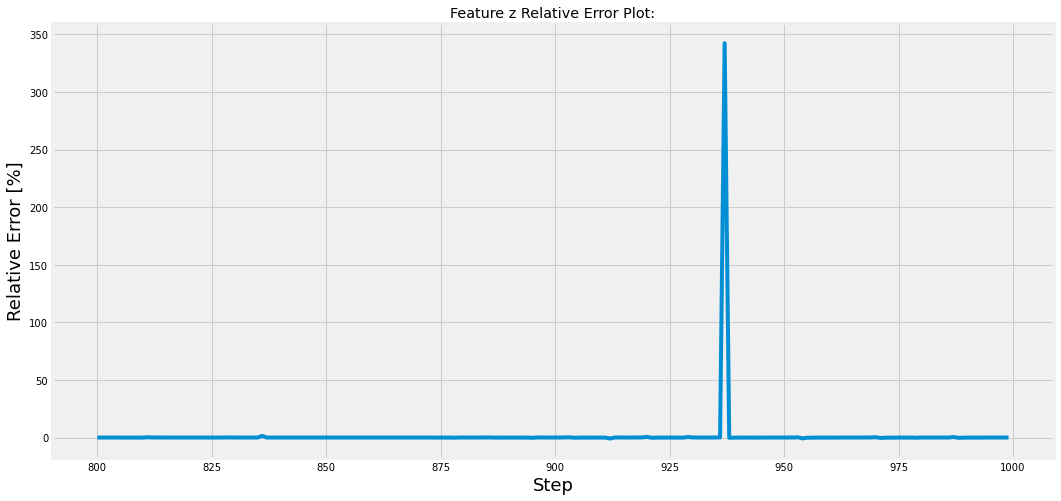

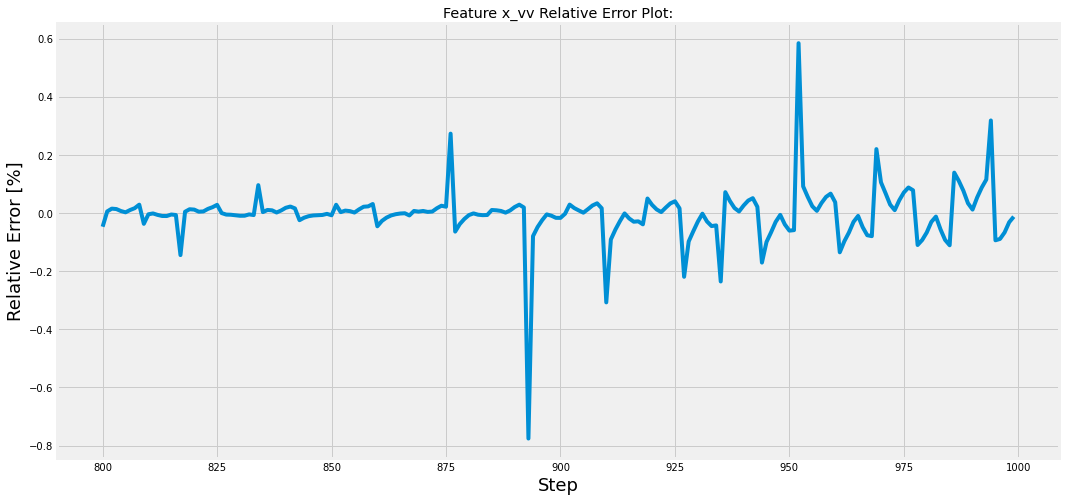

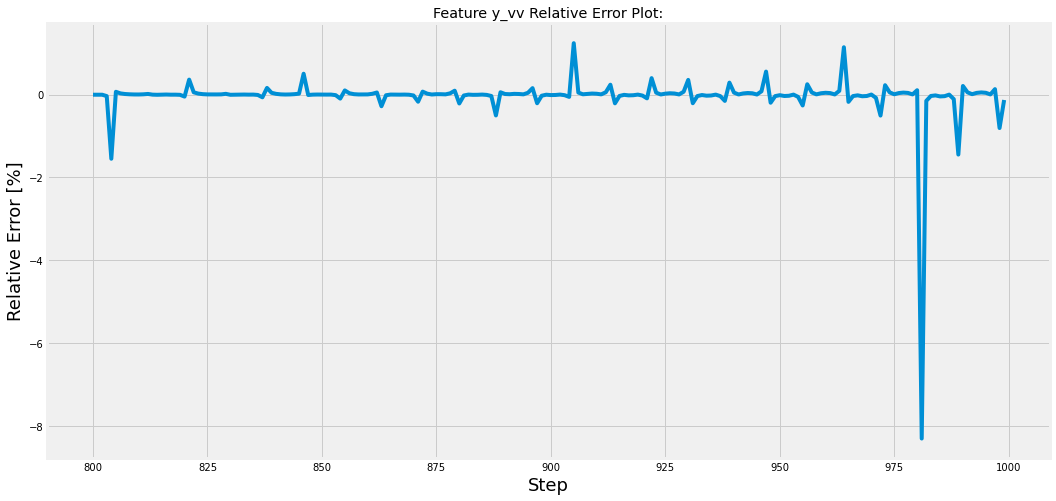

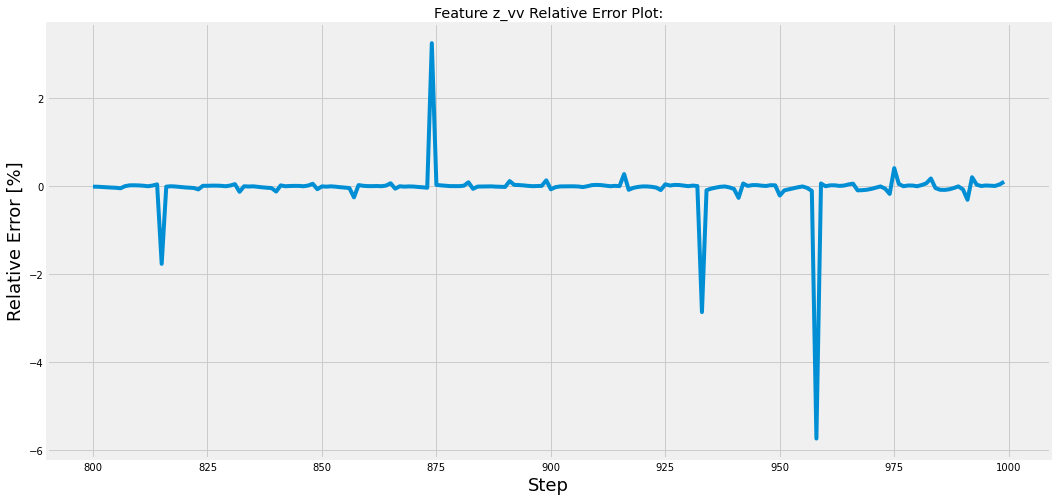

In [20]:
# RELATIVE ERRORS

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/test_df[feature])

    plt.title(f'Feature {feature} Relative Error Plot:')
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Relative Error [%]', fontsize=18)
    plt.show()

In [19]:
# AVG RELATIVE ERRORS:

print('Mean Relative Errors as PERCENTAGE:')
print()
for i in list(test_df.columns):
    print(i)
    abs_err=abs(df_pred[i]-test_df[i])/test_df[i]*100
    print(abs_err.mean())

Mean Relative Errors as PERCENTAGE:

x
4.121713758667563
y
0.15073242886777508
z
171.38209995717153
x_vv
-0.37829211957071535
y_vv
-4.322880683663567
z_vv
-4.092080125954209


## Compare and Plot 3D trajectories/errors:

### 1. For 3D Position coordinates

<Figure size 432x288 with 0 Axes>

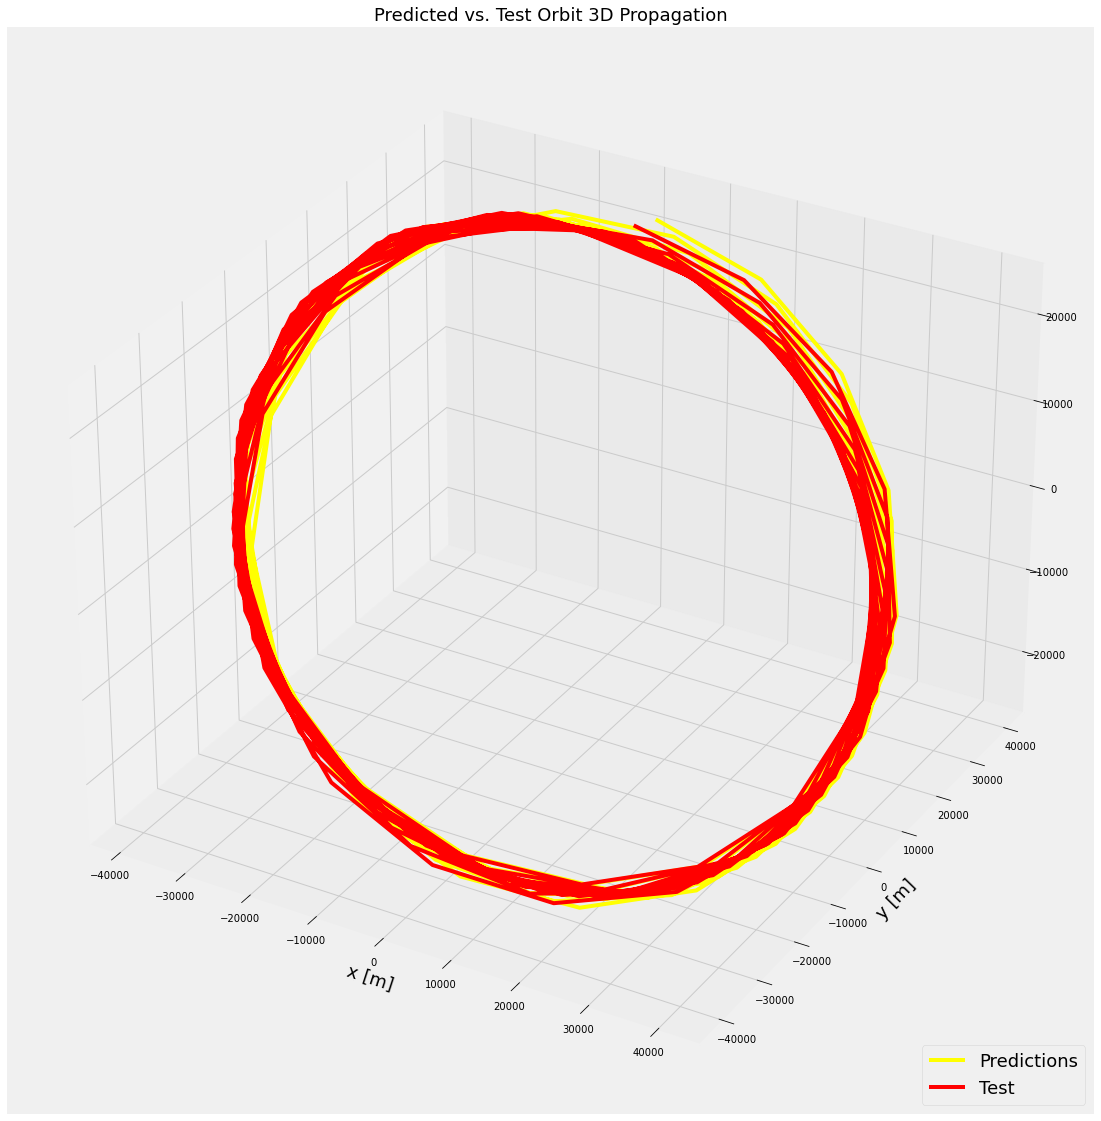

In [11]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'red')

plt.title('Predicted vs. Test Orbit 3D Propagation', fontsize=18)
plt.xlabel('x [m]', fontsize=18)
plt.ylabel('y [m]', fontsize=18)
#plt.zlabel('z [m]', fontsize=18)
plt.legend(['Predictions', 'Test'], loc='lower right', fontsize=18)
plt.show()

### 2. For 3D velocity coordinates

<Figure size 432x288 with 0 Axes>

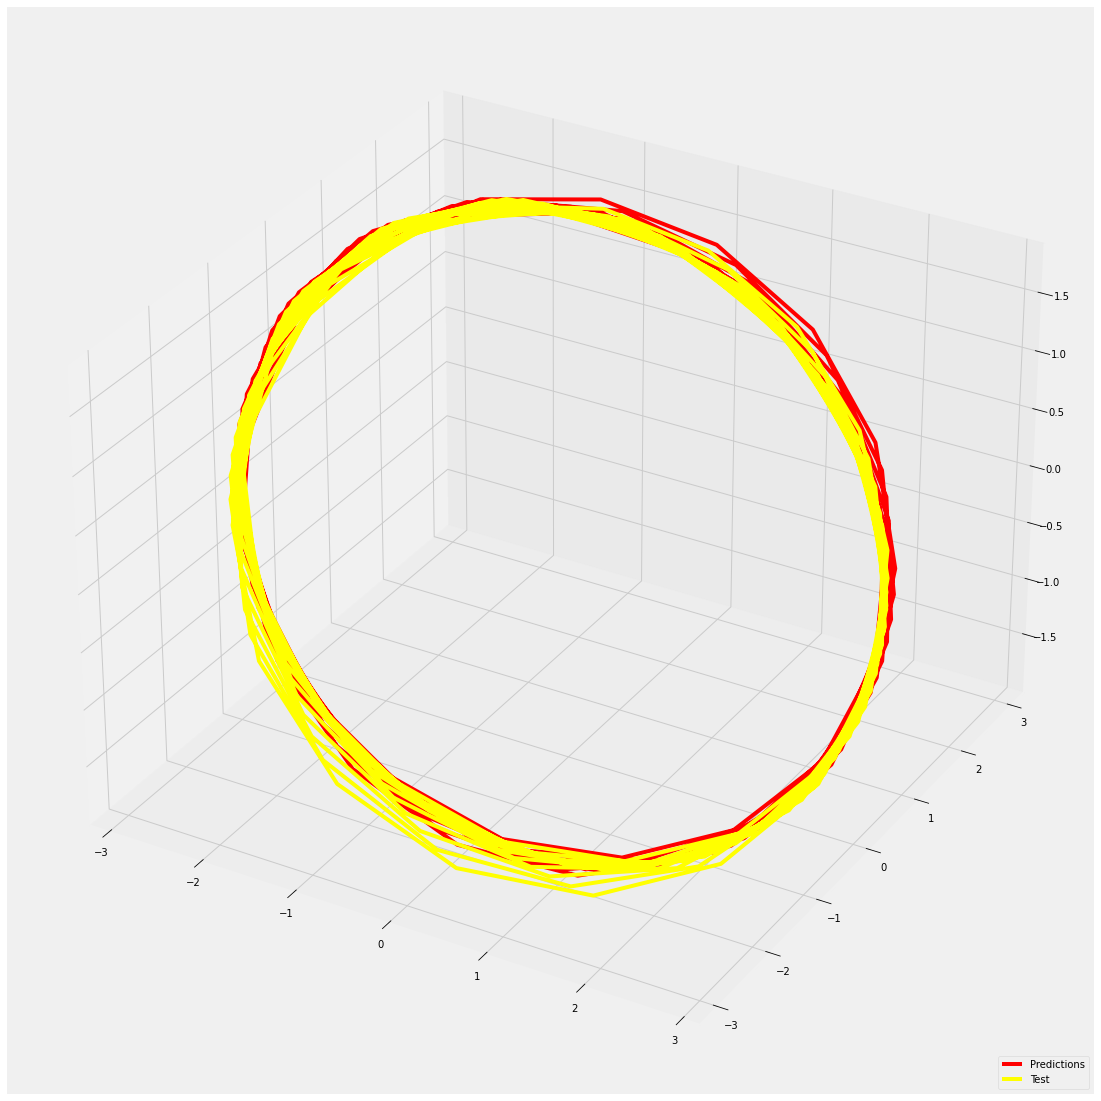

In [12]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x_vv']
y_line = df_pred['y_vv']
z_line = df_pred['z_vv']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x_vv']
y_line2 = test_df['y_vv']
z_line2 = test_df['z_vv']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

## 3D Errors

### 1. Distance Error

https://www.engineeringtoolbox.com/distance-relationship-between-two-points-d_1854.html

In [13]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

df_err

x_test        y_test        z_test        x_pred        y_pred  \
800 -38621.084811  -2550.946846  17682.193978 -38553.335938  -2674.183594   
801 -37279.380962 -16940.060722  11242.557363 -37130.996094 -17018.578125   
802 -30825.302422 -29006.586493   3208.718635 -30704.843750 -29068.347656   
803 -20158.481503 -37068.221540  -5302.080061 -20170.964844 -37206.218750   
804  -6770.864726 -40022.999588 -13103.503585  -6938.910645 -40331.710938   
..            ...           ...           ...           ...           ...   
995  38234.560983  21122.626943  -7729.980003  38273.042969  20538.830078   
996  31594.564686  31056.038869   1622.694286  31021.898438  31027.357422   
997  21172.777063  37155.711937  10779.298456  19702.585938  37131.148438   
998   8179.033302  38600.411058  18585.398385   5910.957031  38058.738281   
999  -5831.459789  35054.731864  23983.498223  -8433.075195  33765.191406   

           z_pred  
800  17448.628906  
801  11080.043945  
802   3121.751465  
803  -5303.611816  
804 -13012.461914  
..            ...  
995  -7661.025391  
996   1664.233643  
997  10721.560547  
998  18253.058594  
999  23214.851562  

[200 rows x 6 columns]

In [14]:
import math

# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))
df_err

x_test        y_test        z_test        x_pred        y_pred  \
800 -38621.084811  -2550.946846  17682.193978 -38553.335938  -2674.183594   
801 -37279.380962 -16940.060722  11242.557363 -37130.996094 -17018.578125   
802 -30825.302422 -29006.586493   3208.718635 -30704.843750 -29068.347656   
803 -20158.481503 -37068.221540  -5302.080061 -20170.964844 -37206.218750   
804  -6770.864726 -40022.999588 -13103.503585  -6938.910645 -40331.710938   
..            ...           ...           ...           ...           ...   
995  38234.560983  21122.626943  -7729.980003  38273.042969  20538.830078   
996  31594.564686  31056.038869   1622.694286  31021.898438  31027.357422   
997  21172.777063  37155.711937  10779.298456  19702.585938  37131.148438   
998   8179.033302  38600.411058  18585.398385   5910.957031  38058.738281   
999  -5831.459789  35054.731864  23983.498223  -8433.075195  33765.191406   

           z_pred  distance_error  
800  17448.628906      272.635010  
801  11080.043945      233.652868  
802   3121.751465      160.897550  
803  -5303.611816      138.569153  
804 -13012.461914      363.084995  
..            ...             ...  
995  -7661.025391      589.113216  
996   1664.233643      574.886751  
997  10721.560547     1471.529469  
998  18253.058594     2355.425462  
999  23214.851562     3003.686901  

[200 rows x 7 columns]

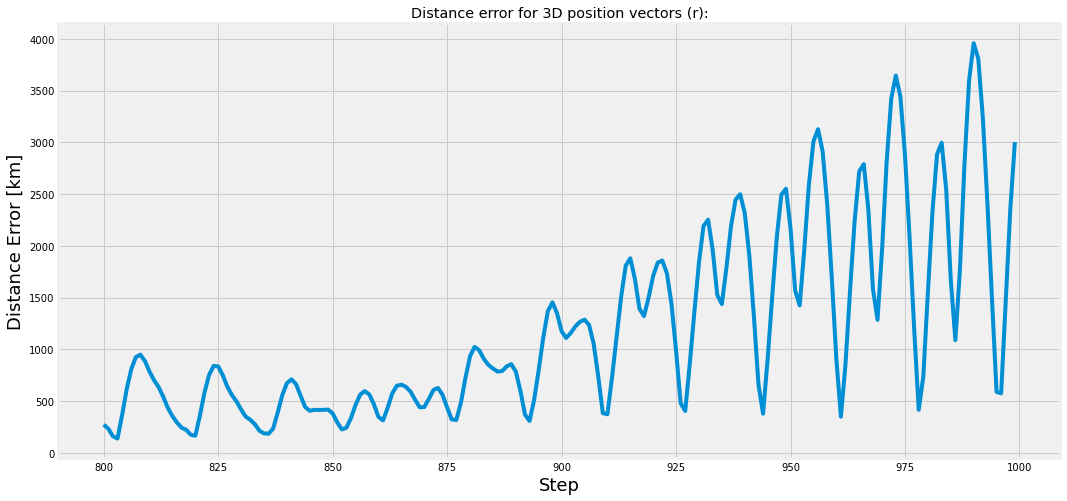

In [21]:
plt.figure(figsize=(16,8))
plt.plot(df_err.distance_error)
plt.title('Distance error for 3D position vectors (r):')
plt.xlabel('Step', fontsize=18)
plt.ylabel('Distance Error [km]', fontsize=18)
plt.show()

### 2. Absolute errors

??

# Numerical Integrated orbit vs Reference